## sklearns's dataset has a data and target key

## Target key holds the labels

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame=False, parser='auto')

mnist.keys()
X, y = mnist['data'], mnist['target']

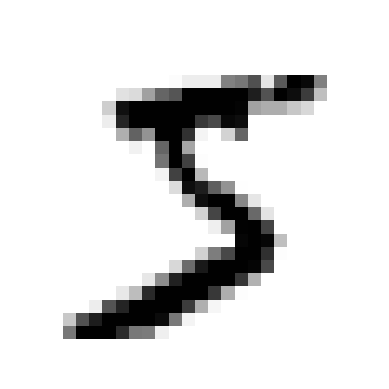

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [3]:
import numpy as np
import pandas as pd
y
y = y.astype(np.uint8)

In [4]:
#MNIST has already a test dataset. First 60,000 are the training set and last 10,000 are the test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
#Only predicting on one digit(5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
#Stochasting gradient dicent(SGD) is suitable to handle large data sets
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
# Applying the model to test if it recognize 5 or not
sgd_clf.predict([some_digit])

array([ True])

# Creating custom cross_validation

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)#folds the data into 3 folds

for train_index, test_index in skfolds.split(X_train, y_train_5):# Iterates through each fold, splitting the data into training and testing sets for that iterations
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]#Training data for the current fold.
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

# Reason why accuracy is not the suited for classifier

In [10]:
# The cross validation shows that it has a 95% to 96% prediction rate but is it though?
from sklearn.base import BaseEstimator

class Never5classifier(BaseEstimator):
    def fit(self,X, y=None):
        return self
    def transform(self, X):
        return np.zeroes((len(X), 1), dtype=bool) 
""" What this dummy class do is: It always predict the data as non 5.
    No matter what input we give this class it will always say it is not 5!"""
# Let's check it's accuracy
never_5_clf = Never5classifier()
"""The following code will show it's accuracy is 90%, because 90% of our is really not 5, so no matter what even though it classifies a non
    5 digit as 5 it's accuracy is 90%.
    This is why accury is bad for classifer."""
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

# Confusion matrix

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Confudion matrix works with prediction so cross_val_predict gives prediction without fitting instead of score.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
# In confusion matrix just pass it the target classes (y_train_5) and the predicted classes(y_train_pred)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

# A perfect confusion matrix

In [12]:
""" Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class. The first row of this matrix considers non-5 images (the nega‐
tive class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,891 were wrongly
classified as non-5s (false negatives), while the remaining 3530 were correctly classi‐
fied as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right) """

y_train_perfect_prediction = y_train_5 # Giving it the target set
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In [13]:
# Precision: Precision means form your positive prediction how many was was really positive?
# Recall: Recall means form the positive values(aka the target values) how many was really predicted?
# Also import note treshold and Precision are correlated means by increasing treshold value will also incease Precision rate
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # How many was was really positive from your prediction?
print(recall_score(y_train_5, y_train_pred)) # From the target value how many did you correctly predicted?

0.8370879772350012
0.6511713705958311


In [14]:
# ^^^^ 83% from the prediction was correct and 63% was correctly recognized as 5. Not a good result

# F1 score

In [15]:
# F1 score combines the precision and recall score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [16]:
""" Important note: F1 score returns true positive, in some contexts you mostly care about precision, and in other con‐
texts you really care about recall. For example, if you trained a classifier to detect vid‐
eos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeof. """


""" High Precision (minimizing false positives) examples:

    Fraud Detection: Prioritize precision to ensure that only truly fraudulent transactions are flagged, avoiding unnecessary customer inconvenience and investigation costs.
    Medical Diagnosis: In critical conditions like cancer or heart disease, high precision is crucial to avoid false positives that could lead to unnecessary treatments or anxiety.
    Spam Detection: Email filters need high precision to prevent legitimate emails from being incorrectly marked as spam, ensuring important messages reach users.
    Product Recommendation Systems: High precision ensures that only highly relevant products are recommended to users, avoiding negative experiences and potential churn.
    Security Systems: Alarms and intrusion detection systems should have high precision to minimize false alarms, preventing unnecessary responses and resource allocation.

    
    High Recall (minimizing false negatives) examples:
    
    Cancer Screening: Prioritize recall to detect as many potential cancer cases as possible, even at the cost of some false positives that can be further investigated.
    Information Retrieval: Search engines strive for high recall to ensure they retrieve most relevant documents for a query, even if it means including some less relevant results.
    Surveillance Systems: High recall is crucial for identifying potential threats or criminal activity, even if it means reviewing some false alarms.
    Natural Language Processing (NLP): Named entity recognition systems require high recall to identify most named entities in a text, even if it includes some incorrect identifications.
    Manufacturing Defect Detection: Prioritize recall to catch as many defective products as possible, even if it means inspecting some non-defective ones."""

' High Precision (minimizing false positives) examples:\n\n    Fraud Detection: Prioritize precision to ensure that only truly fraudulent transactions are flagged, avoiding unnecessary customer inconvenience and investigation costs.\n    Medical Diagnosis: In critical conditions like cancer or heart disease, high precision is crucial to avoid false positives that could lead to unnecessary treatments or anxiety.\n    Spam Detection: Email filters need high precision to prevent legitimate emails from being incorrectly marked as spam, ensuring important messages reach users.\n    Product Recommendation Systems: High precision ensures that only highly relevant products are recommended to users, avoiding negative experiences and potential churn.\n    Security Systems: Alarms and intrusion detection systems should have high precision to minimize false alarms, preventing unnecessary responses and resource allocation.\n\n    \n    High Recall (minimizing false negatives) examples:\n    \n    C

# Decision function

In [17]:
# The decision_function method of the SGDClassifier doesn't directly make class predictions. It returns decision scores,
# which represent how strongly the model believes a sample belongs to a particular class.
y_score = sgd_clf.decision_function([some_digit]) # y_soces shows the confidence level of sgd_clf
y_score

array([2164.22030239])

# Finding the best treshold

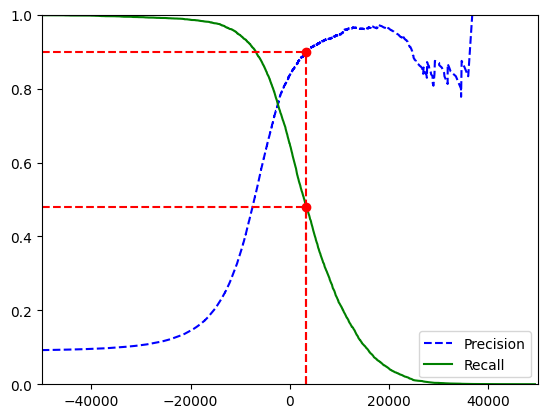

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3, method="decision_function") # Shows the confidence for each intences

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# By visualizing the recall and precision relationship, we can identify the best threshold
def plot_precision_recall_vs_threshold( precisions, recalls, thresholds ):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.plot()
    plt.axis([-50000,50000, 0,1])
    plt.legend()
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # A point in recalls curve where precision reached 90% 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # A point in precision where it is 90%

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# The following will highlight the point where precision is 90%
plt.plot([threshold_90_precision, threshold_90_precision],[.0, .9], "r--")
plt.plot([-50000,threshold_90_precision,],[.9,.9], "r--")
plt.plot([-50000,threshold_90_precision],[recall_90_precision,recall_90_precision], "r--")
plt.plot([threshold_90_precision,threshold_90_precision],[0.,recall_90_precision], "r--")
plt.plot(threshold_90_precision,.9,"ro")
plt.plot(threshold_90_precision, recall_90_precision,"ro")
plt.show()

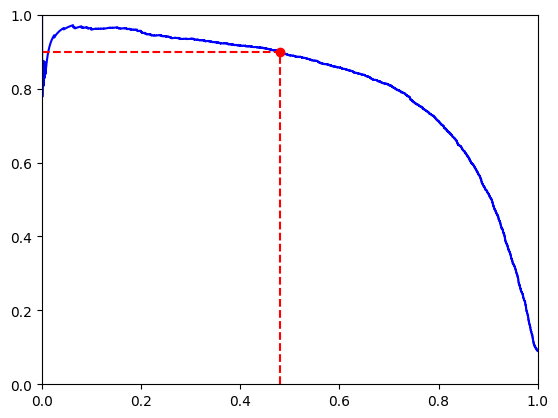

In [19]:
# Finding precision recall tradeoff
def recall_vs_precision(recalls, precisions):# It also highlight the place where the precision is 90%
    plt.plot(recalls, precisions, 'b-', label = ['Recall','Precision'])
    plt.plot([0.,recall_90_precision],[.9,.9],"r--")
    plt.plot([recall_90_precision,recall_90_precision],[.0,.9],"r--")
    plt.plot(recall_90_precision,.9,"ro")
    plt.axis([0,1,0,1])
    plt.show()

recall_vs_precision(recalls, precisions)

In [20]:
"""You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall. But of course the choice depends on your project."""

"""So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value,"""

'So let’s suppose you decide to aim for 90% precision. You look up the first plot and\nfind that you need to use a threshold of about 8,000. To be more precise you can\nsearch for the lowest threshold that gives you at least 90% precision (np.argmax()\nwill give us the first index of the maximum value,'

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= .90)]
threshold_90_precision # This will be the place where the precision is 90%

3370.0194991439557

In [22]:
# Let's check if it is really 90% or not
y_train_pred_90_precision = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90_precision)

0.9000345901072293

In [23]:
recall_score(y_train_5, y_train_pred_90_precision)

0.4799852425751706

# ROC(receiver operating characteristic) plot TPR vs FPR

In [24]:
from sklearn.metrics import roc_curve
# fpr = false positive rate, tpr = true positive rate(aka recall)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

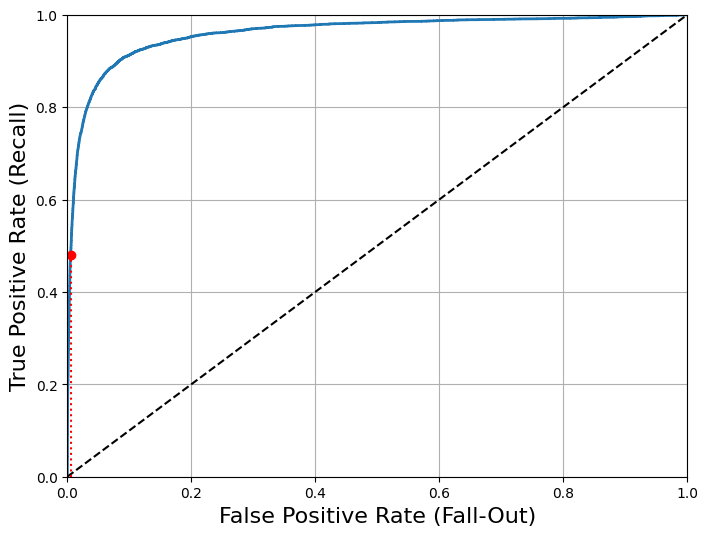

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [26]:
"""Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner)."""

'Once again there is a tradeoff: the higher the recall (TPR), the more false positives\n(FPR) the classifier produces. The dotted line represents the ROC curve of a purely\nrandom classifier; a good classifier stays as far away from that line as possible (toward\nthe top-left corner).'

# AUC(area under the curve)

In [27]:
"""One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5."""
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# ROC or PR(precision/recall) which one to choose?

In [28]:
"""Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier

has room for improvement (the curve could be closer to the top-
right corner)."""

'Since the ROC curve is so similar to the precision/recall (or PR)\ncurve, you may wonder how to decide which one to use. As a rule\nof thumb, you should prefer the PR curve whenever the positive\nclass is rare or when you care more about the false positives than\nthe false negatives, and the ROC curve otherwise. For example,\nlooking at the previous ROC curve (and the ROC AUC score), you\nmay think that the classifier is really good. But this is mostly\nbecause there are few positives (5s) compared to the negatives\n(non-5s). In contrast, the PR curve makes it clear that the classifier\n\nhas room for improvement (the curve could be closer to the top-\nright corner).'

In [29]:
from sklearn.ensemble import RandomForestClassifier # measuring a random forest's roc curve

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method ="predict_proba") # Due to the way forest work it do not 
# have decision tree, but the predict_proba return the probabily of each instenses
# By taking the first column if this which is the positive column can be used as scores
y_scores_forest = y_probs_forest[:, 1]

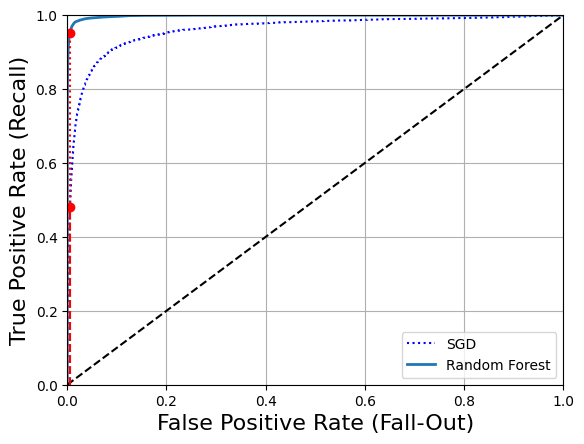

In [30]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90],[0.,recall_90_precision], "r--")
plt.plot(fpr_90, recall_90_precision,"ro")
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.legend(loc="lower right")
plt.show()

In [31]:
print("Random forest's scores:")
print('Roc Auc:', roc_auc_score(y_train_5, y_scores_forest))
y_only_preds_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
print("Rcall:", recall_score(y_train_5, y_only_preds_forest))
print("Precision:", precision_score(y_train_5, y_only_preds_forest))

Random forest's scores:
Roc Auc: 0.9983436731328145
Rcall: 0.8662608374838591
Precision: 0.9905083315756169


In [32]:
# ^^^ It seems that Random forest do better than sgd_classifier with 99% precision, 86% recall!!!

# Multiclass classifier

In [33]:
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [34]:
some_digit_scores = sgd_clf.decision_function([some_digit]) # Now instead of one score it will give 10 score,
# Because under the hood the sgd_clf is trainning on 10 different digit and giving the result of the best prediction
some_digit_scores
"""When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In this case, the index of each
class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky."""
sgd_clf.classes_ 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Specifying One vs One and One vs All

In [35]:
# We can tell the model which methid we want to use
from sklearn.multiclass import OneVsRestClassifier # One vs All
from sklearn.multiclass import OneVsOneClassifier # One vs One

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_) # N × (N – 1) / 2 <--- The law to find the one vs one classifier numbers, N represents the number of classes

45

In [36]:
# ^^^^ there are 10 classes so 45 one vs one classifier

In [37]:
# Random forest case is easy cause it always do one vs one
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

# Evaluating classifier and scaling features

In [38]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [40]:
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')
# This score will be higher than before, for laging issues I am prosponding this process

# Error analysing

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 2)
conf_matrix = confusion_matrix(y_train, y_train_pred)

/home/arman/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


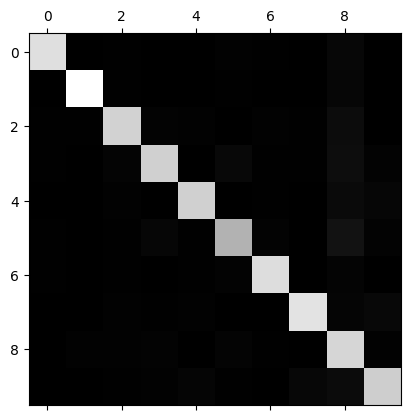

In [42]:
plt.matshow(conf_matrix, cmap = plt.cm.gray)
plt.show()

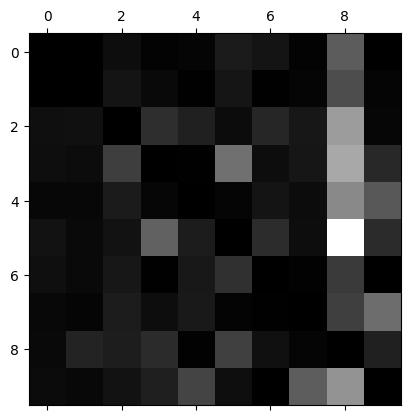

In [43]:
"""you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error
rates instead of absolute number of errors (which would make abundant classes look
unfairly bad)"""
rows_sum = conf_matrix.sum(axis = 1, keepdims = True) # Sumup each rows values
norm_conf_mx = conf_matrix / rows_sum # Error rate of each attribs
np.fill_diagonal(norm_conf_mx, 0) # Make the make diagonal black as 0 means no error.
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Explicitely visualizing why 3,5 is not properly predicted

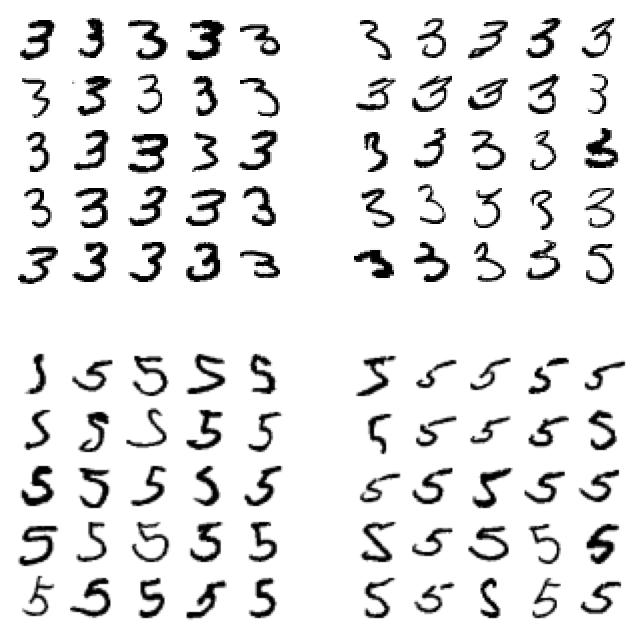

In [44]:
# Row represints the classes and the column represents the predictions
# Explicitely seeing the the 3s,5s error reason
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row) # Ensures no more than images_per_row images are displayed per row.
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1 #Calculates the required number of rows.

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0) #Appends empty images to create a rectangular grid.

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    """transpose(0, 2, 1, 3) rearranges these dimensions in a specific order:

    Axis 0 (rows) stays in place.
    Axis 2 (individual image pixels) is moved to the second position.
    Axis 1 (images within a row) is shifted to the third position.
    Axis 3 (remaining pixel dimension) stays in the last position."""
    """Why This Rearrangement?

    Visualizing Grids: plt.imshow() expects a 2D array representing a single image."""
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
cl_a, cl_b = 3,5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # Extracting features of that prediction that is labeled as 3 and also predicted
                                                           # as 3(we want to know the way how the model is predicting that it's prediction
                                                           # is so worse)
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # images that are actually 3 but predicted as 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # images that are actually 5 but predicted as 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

# Multilabel Clssification

In [45]:
"""A classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classiication system."""

'A classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then\nwhen it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning\n“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple\nbinary tags is called a multilabel classiication system.'

In [46]:
from sklearn.neighbors import KNeighborsClassifier #KNeighborsClassifier instance (which supports multilabel classification, but not all classifiers do)

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [47]:
knn_clf.predict([some_digit])

array([[False,  True]])

# Evaluation multilabel

In [48]:
"""There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F1
score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average F1
score across all
labels"""
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
# If you have 5 labels with F1 scores of 0.9, 0.85, 0.7, 0.95, and 0.8, the macro-average would be (0.9 + 0.85 + 0.7 + 0.95 + 0.8) / 5 = 0.84.
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [49]:
""" ^^^^^ 
This assumes that all labels are equally important, which may not be the case. In par‐
ticular, if you have many more pictures of Alice than of Bob or Charlie, you may want
to give more weight to the classifier’s score on pictures of Alice. One simple option is
to give each label a weight equal to its support (i.e., the number of instances with that
target label). To do this, simply set average="weighted" in the preceding code.4"""

""" From the officail documentary:
     
average{‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} or None, default=’binary’

    This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

    'binary':

        Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.
    'micro':

        Calculate metrics globally by counting the total true positives, false negatives and false positives.
    'macro':

        Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    'weighted':

        Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
    'samples':

        Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

"""

" From the officail documentary:\n     \naverage{‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} or None, default=’binary’\n\n    This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:\n\n    'binary':\n\n        Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.\n    'micro':\n\n        Calculate metrics globally by counting the total true positives, false negatives and false positives.\n    'macro':\n\n        Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.\n    'weighted':\n\n        Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and re

# Multioutput Classification

In [50]:
"""As the name suggest the model will guess multiple things and output mulpliple values at the same time,
    for example: seeing a person's sunglasses, t-shirt color, bagpack.... it can predict the person's fav. color, where he would go(
    suppose beach, cause he a sunglass), if he is planning a trip or not(seeing the backpack)"""

"""To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐
sented as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system."""

'To illustrate this, let’s build a system that removes noise from images. It will take as\ninput a noisy digit image, and it will (hopefully) output a clean digit image, repre‐\nsented as an array of pixel intensities, just like the MNIST images. Notice that the\nclassifier’s output is multilabel (one label per pixel) and each label can have multiple\nvalues (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput\nclassification system.'

In [51]:
noise = np.random.randint(0, 100, (len(X_train), 784))
"""Creates a matrix of random integers between 0 and 99 (inclusive) with the same shape as
X_train (same number of rows and 784 columns)."""
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_test_mod = X_test
y_train_mod = X_train

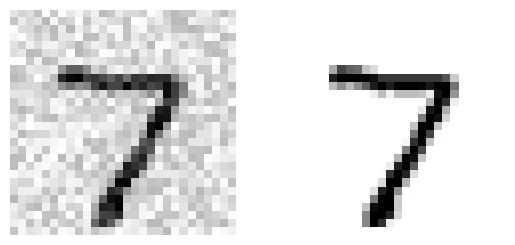

In [52]:
# Taking a peek at the training and test set
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

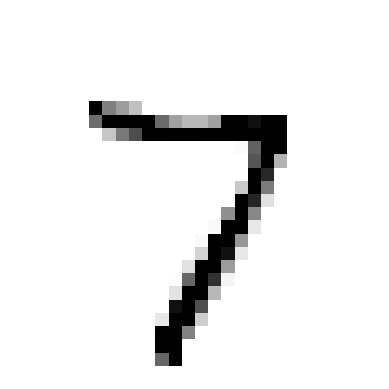

In [53]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)